In [1]:
from PIL import Image
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
from utils.fundus_prep import PreprocessEyeImages
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

import torch.backends.cudnn as cudnn
import argparse
import os

class ResNet:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.classes = ['Age-related macular degeneration (AMD) DETECTED', 'NEGATIVE for AMD']

        self.model = torchvision.models.resnet18()
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 2)

        self.model.load_state_dict(torch.load(os.path.join('weights/resnet18_weight.pt'), map_location=self.device ))
        self.model.eval()
        self.model = self.model.to(self.device)

    
    def infer(self, image_path):
        input_image = Image.open(image_path)
        preprocess = transforms.Compose([
                PreprocessEyeImages(),
                transforms.Resize(390),
                transforms.CenterCrop(256),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        input_tensor = preprocess(input_image)

        # create a mini-batch as expected by the model
        input_batch = input_tensor.unsqueeze(0)
        input_batch = input_batch.to(self.device)

        with torch.no_grad():
            output = self.model(input_batch)

        # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
        output = output.softmax(-1)
        confidence, index = torch.max(output[0], 0)

        #save prep
        prep_img, heat_img = self.gradCam( input_batch )

        return (self.classes[index.item()], confidence.item(), prep_img, heat_img)


    def gradCam(self, input_batch):
        #save prep
        img = input_batch.squeeze(0)
        inp = img.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        rgb_img = np.clip(inp, 0, 1)

        target_layer = self.model.layer4[-1]

        # Construct the CAM object once, and then re-use it on many images:
        cam = GradCAM(model=self.model, target_layer=target_layer)
        cam.batch_size = 82

        target_category = None

        # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
        grayscale_cam = cam(input_tensor=input_batch, target_category=target_category)

        grayscale_cam = grayscale_cam[0, :]

        cam_image = show_cam_on_image(rgb_img, grayscale_cam)

        return Image.fromarray( (rgb_img * 255).astype(np.uint8) ), Image.fromarray( cam_image[:, :, ::-1] )

Classification: Age-related macular degeneration (AMD) DETECTED
Confidence: 0.99989


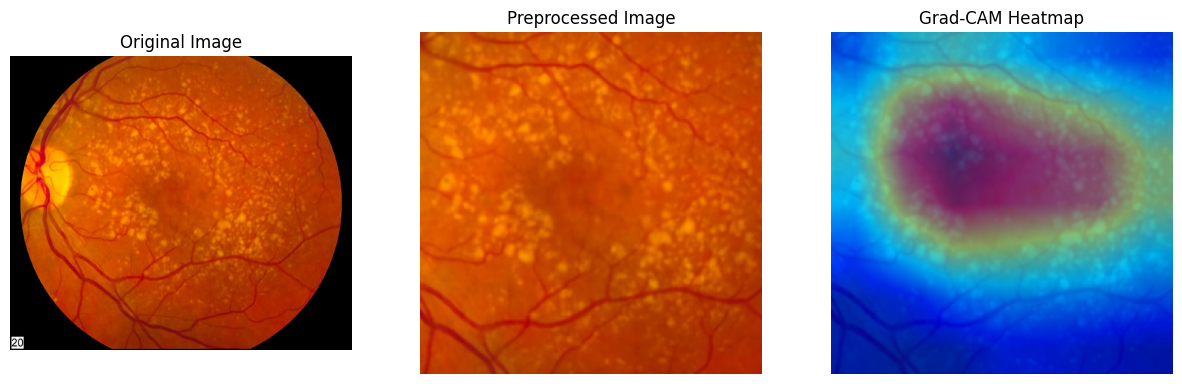

In [2]:
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Initialize the ResNet class
model = ResNet()

# For demonstration, we use a sample image (assuming it's an eye image)
# Normally, you would load a specific image file here
sample_image_path = 'assets/amd_retina.jpg' # Replace with the path of a real eye image

# Running inference on the sample image
result = model.infer(sample_image_path)

# Extract the outputs
classification, confidence, prep_img, heat_img = result

#print classification and confidence
print(f"Classification: {classification}")
print(f"Confidence: {confidence:.5f}")

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Image.open(sample_image_path))
axs[0].set_title("Original Image")
axs[1].imshow(prep_img)
axs[1].set_title("Preprocessed Image")
axs[2].imshow(heat_img)
axs[2].set_title("Grad-CAM Heatmap")

for ax in axs:
    ax.axis('off')

plt.show()